# Predicting Subreddits from Post Titles

---
### Goal
The goal of this project is to use natural language processing to accurately predict the subreddit based on the title of a post.

### Data
The data for this project includes all posts made to a specific set of tech related subreddits (message boards) during the month of December 2016, along with some additional data (the number of upvotes from the community, the number of comments made on the post, etc.) This data has been subset to only self-posts (posts where the writer has submitted text instead of a link elsewhere).

This dataset was parsed and retrived for the Data Science Immersive course at General Assembly by one of the instructors. 

## Notebook Contents
---
- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#fe)
- [Downsample Majority Classes](#downsample)
- [Random Forest Classifier](#rfc)
- [Gradient Boosting Classifier](#gbc)
- [Downsampled Random Forest Classifier](#resample rfc)
- [Downsampled Gradient Boost Classifier](#resample gbc)
- [Word Frequency by Subreddit](#frequency) 
- [Conclusions & Takeaways](#conclusions)

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import random
import re
import string

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt

from wordcloud import WordCloud,STOPWORDS

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='eda'></a>
## Exploratory Data Analysis

In [2]:
df = pd.read_csv('reddit_posts.csv')
print(df.shape)
df.head(2)

(26688, 53)


adserver_click_url  adserver_imp_pixel  archived          author  \
0                 NaN                 NaN     False  johnnyawesome0   
1                 NaN                 NaN     False    Silverfin113   

  author_flair_css_class author_flair_text  contest_mode  created_utc  \
0                    NaN               NaN         False   1480697304   
1                    NaN               NaN         False   1480697424   

   disable_comments distinguished  \
0               NaN           NaN   
1               NaN           NaN   

                         ...                         spoiler  stickied  \
0                        ...                           False     False   
1                        ...                           False     False   

          subreddit  subreddit_id  third_party_tracking  \
0       techsupport      t5_2qioo                   NaN   
1  learnprogramming      t5_2r7yd                   NaN   

   third_party_tracking_2 thumbnail                      title   ups  \
0                     NaN      self     Help with audio set-up   1.0   
1                     NaN      self  Optimizing code for speed  23.0   

                                                 url  
0  https://www.reddit.com/r/techsupport/comments/...  
1  https://www.reddit.com/r/learnprogramming/comm...  

[2 rows x 53 columns]

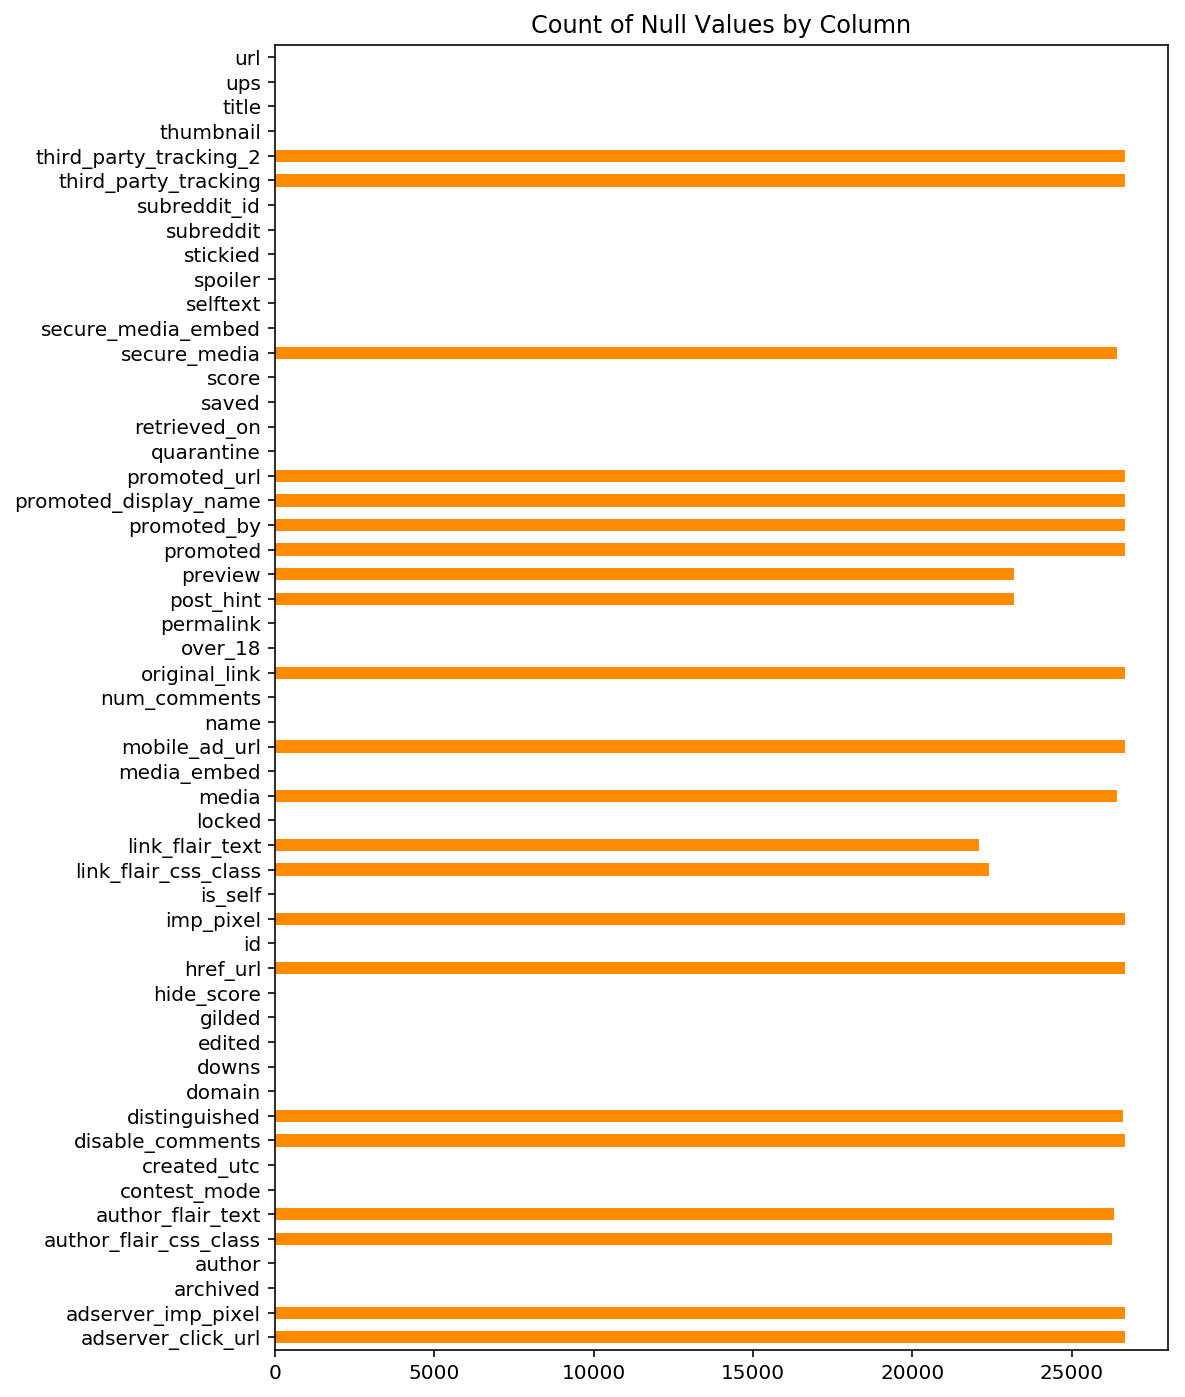

In [3]:
# visually represent all null values & columns names in the dataset
plt.subplots(figsize=(8,12))
plt.title('Count of Null Values by Column')
df.isnull().sum().plot(kind='barh', color = 'DarkOrange');

This dataset contains 53 features, many of which are entirely null. Given the title of the remaining features and the goal of this project (create a classification model using NLP), I decided to subset the data to include only text features. With this project, I want to be able to make predictions on what subreddit a post should be assigned based on its title.

In [4]:
# create a new dataframe with text columns
df = df[['selftext','subreddit','title','ups']]
df.head()

selftext         subreddit  \
0  I have a Sony surround sound system for a blu-...       techsupport   
1  I've written what seems to be a prohibitively ...  learnprogramming   
2  I'm writing an article called "Video Games Tha...           gamedev   
3                                          [deleted]  learnprogramming   
4  I have the following representation of argumen...       learnpython   

                                               title   ups  
0                             Help with audio set-up   1.0  
1                          Optimizing code for speed  23.0  
2  Seeking Tales of Development Woe (and Triumph)...  12.0  
3          [Java] Finding smallest value in an array   0.0  
4                 currying functions using functools   6.0

In [5]:
# confirm dtypes are as expected
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 4 columns):
selftext     26688 non-null object
subreddit    26688 non-null object
title        26688 non-null object
ups          26688 non-null float64
dtypes: float64(1), object(3)
memory usage: 834.1+ KB


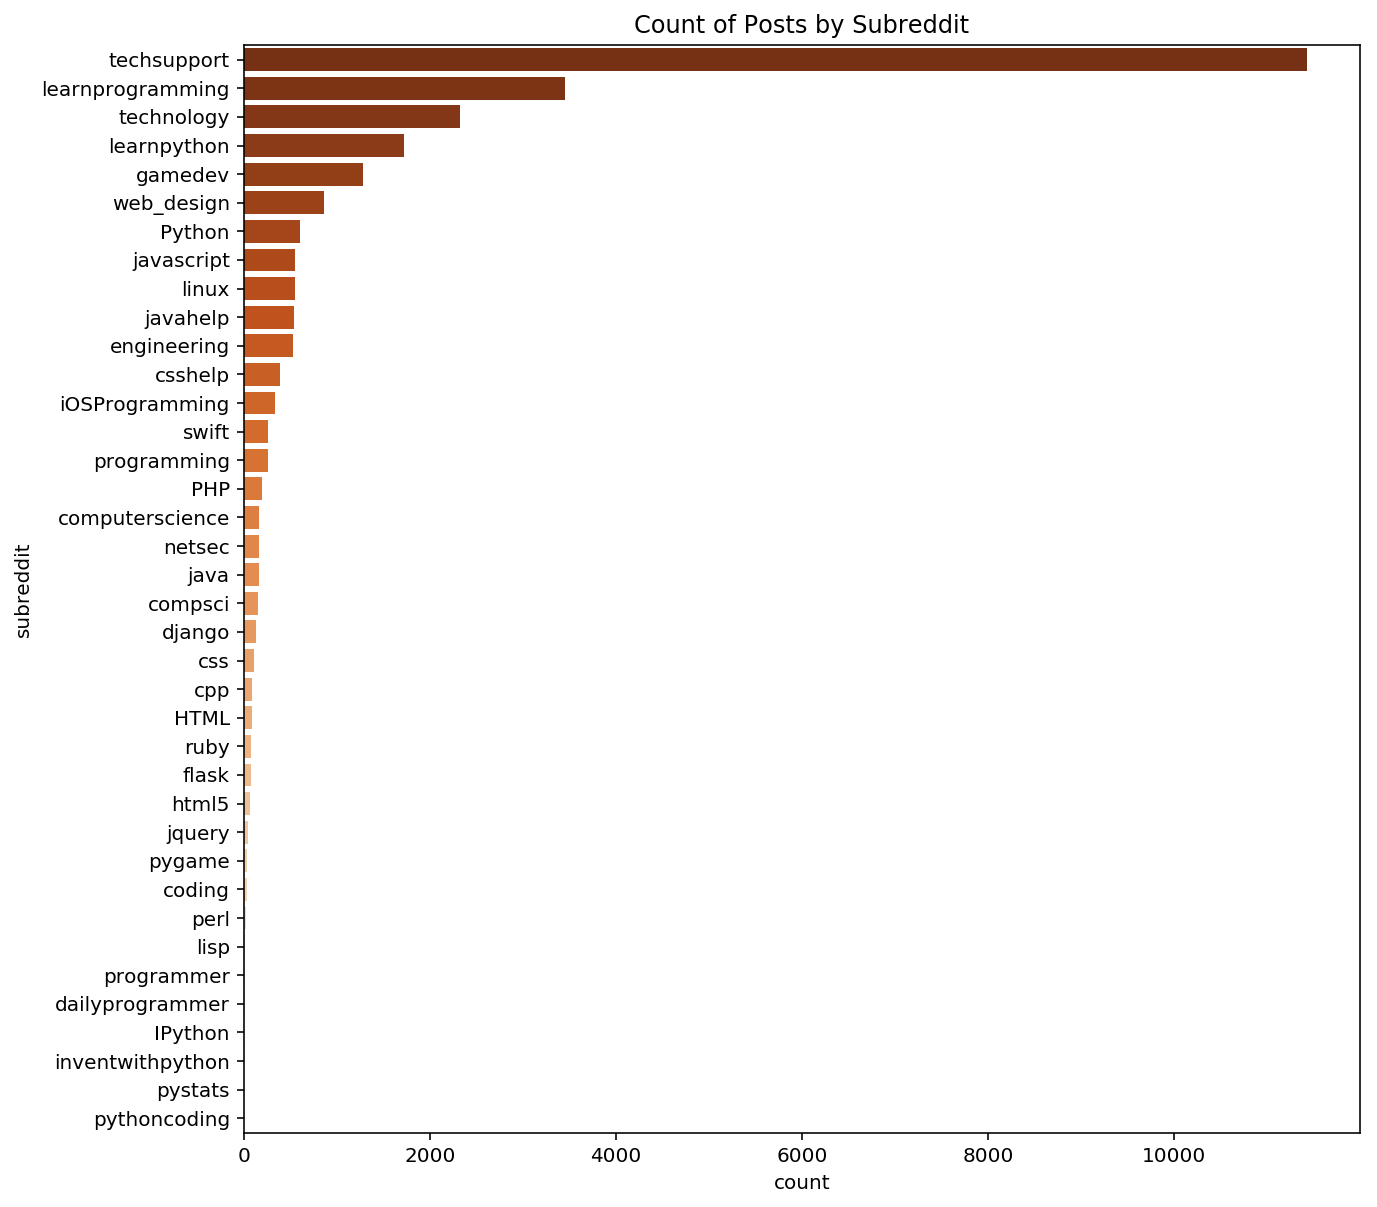

In [6]:
# how is the data distributed between the subreddits
plt.subplots(figsize=(10,10)) 
plt.xticks(ha='center')
plt.title("Count of Posts by Subreddit")
sns.countplot(y='subreddit',data = df, palette='Oranges_r', 
              order = df.subreddit.value_counts().index);

The dataset is disproportionately techsupport. I expect to do some type of downsampling when I reach the modeling stage.

Many of the subreddit names are similar (pythoncoding, IPython, inventwithpython) and for the purpose of this project getting a subreddit that's in the correct ballpark, even if it's not the exact subreddit, will still work. To deal with the data sparcity & complexity I will consolidate those similar subreddits.

In [7]:
# consolidate similar subreddits
subreddit_dict = {'pythoncoding':'Python','pystats':'Python','inventwithpython':'Python',
                 'IPython':'Python','pygame':'Python','learnpython':'Python',
                  'dailyprogrammer':'programming', 'programmer':'programming'}
df.subreddit.replace(subreddit_dict, inplace=True)

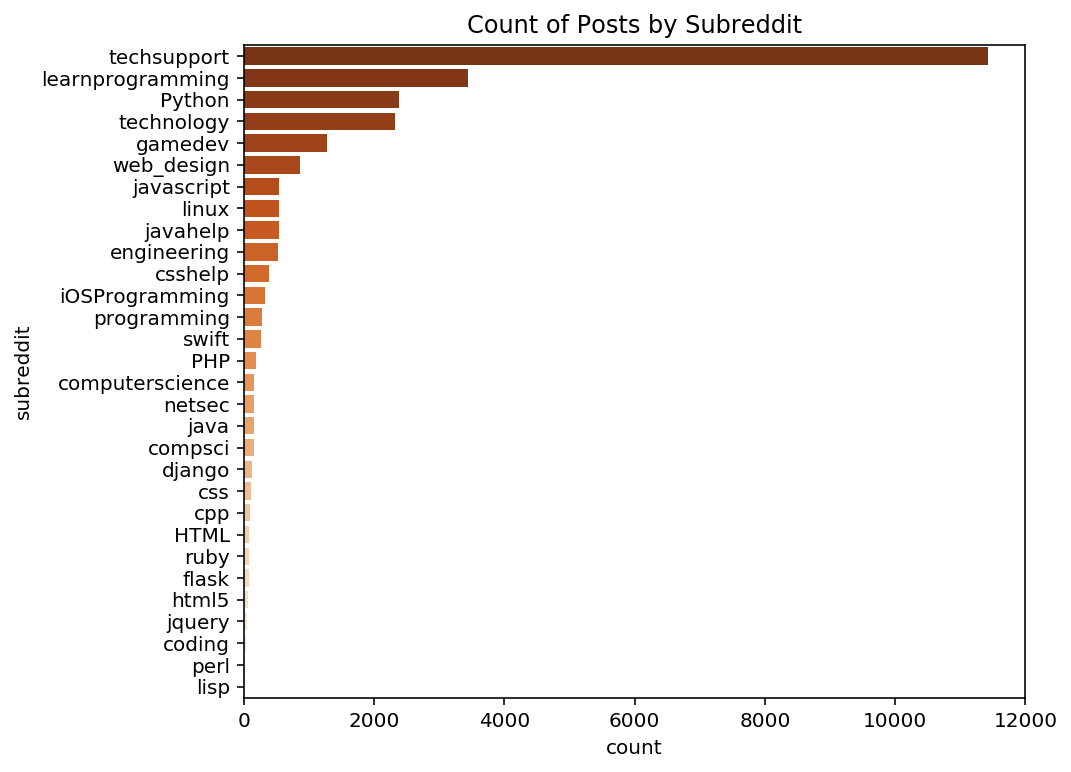

In [8]:
plt.subplots(figsize=(7,6)) 
plt.xticks(ha='center')
plt.title("Count of Posts by Subreddit")
sns.countplot(y='subreddit',data = df, palette='Oranges_r', 
              order = df.subreddit.value_counts().index);

Above is the resulting subreddit distribution after consolidating subreddits with similar topics. I limited the dataset to only include the top 10 subreddits due to the minimal data in the remaining categories.

In [9]:
#limit the subreddits to the ones with the largest counts
df = df[(df.subreddit.isin(['techsupport','learnprogramming','technology',
                           'Python','gamedev','web_design','javascript',
                           'linux','javahelp','engineering']))]

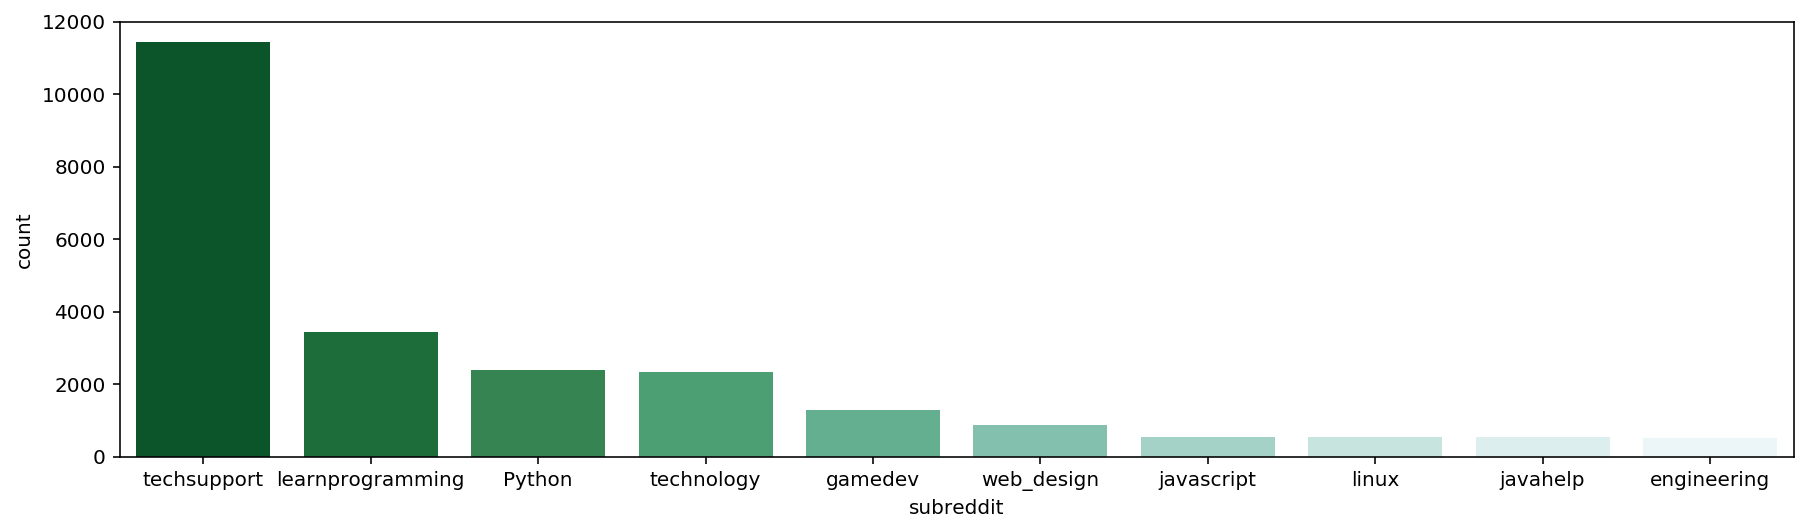

In [10]:
plt.subplots(figsize=(15,4)) 
plt.xticks(rotation=0, ha='center')
sns.countplot(x='subreddit', data = df, palette='BuGn_r',
              order = df.subreddit.value_counts().index);

Users tend to use the most words when titling posts in the technology subreddit and least for posts in the engineering subreddit. All titles, however, range between 7-10 words 

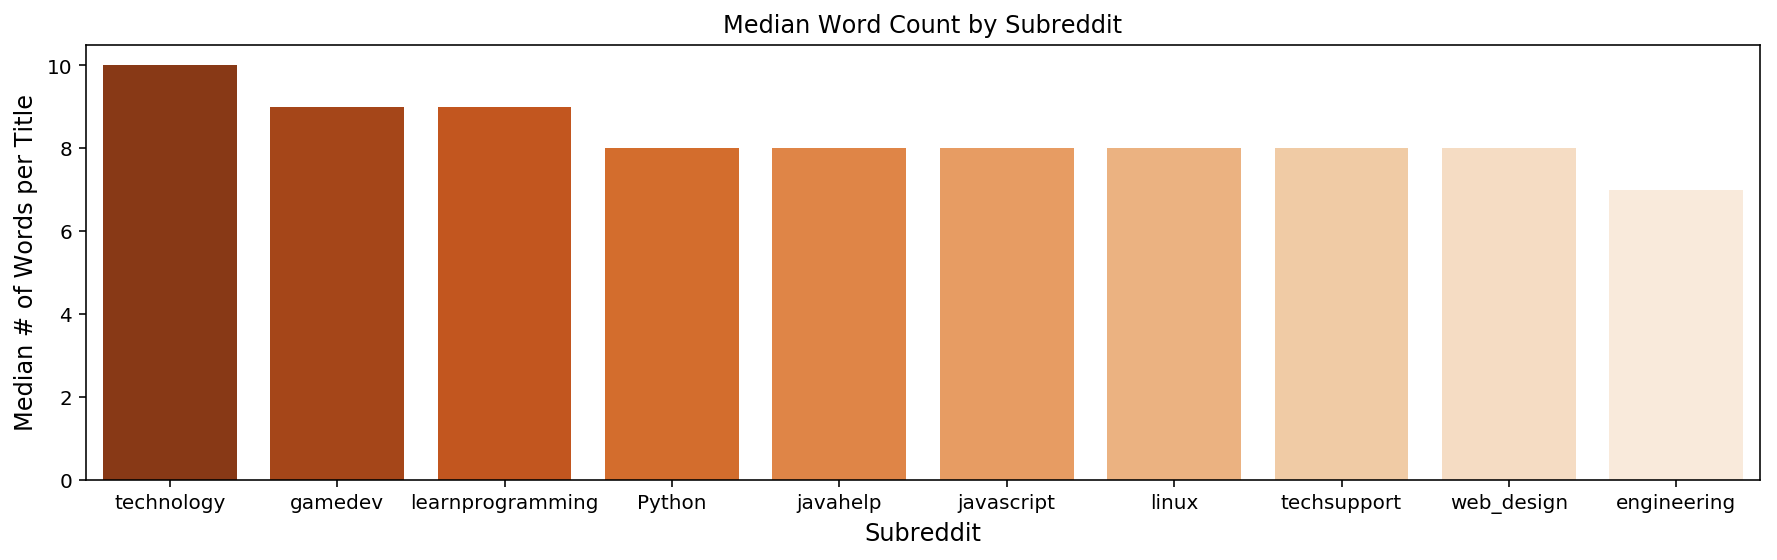

In [11]:
df['word_count'] = df['title'].apply(lambda x: len(re.findall(r'\w+', x)))

subreddit_words = pd.DataFrame(df.groupby('subreddit')['word_count'].median())
subreddit_words.reset_index(inplace = True)
plt.figure(figsize=(15,4))
sns.barplot(subreddit_words['subreddit'], subreddit_words['word_count'], 
            palette='Oranges_r', 
            order = subreddit_words.sort_values(['word_count'],ascending=False).subreddit)
plt.ylabel('Median # of Words per Title', fontsize=12)
plt.xlabel('Subreddit', fontsize=12)
plt.title('Median Word Count by Subreddit');

### WordClouds to visualise each subreddit's title

I created word clouds for the original title for each subreddit to visualize the distinct words that make up the titles and their relative frequencies. There's nothing surprising about the majority of the words founds in the wordclouds, however, we can see some that there are some overlapping common words. The _learnprogramming_ subreddit contains words that occur in the titles of other reddits such as **python** and **java**. Overall, **help** & **need** are commonly occuring words in all of the subreddits. Based on these two inferences, I will use the TFIDF vectorizer as my preprocessor so that the words that occur frequently in all subreddits don't bias the subsequent models.

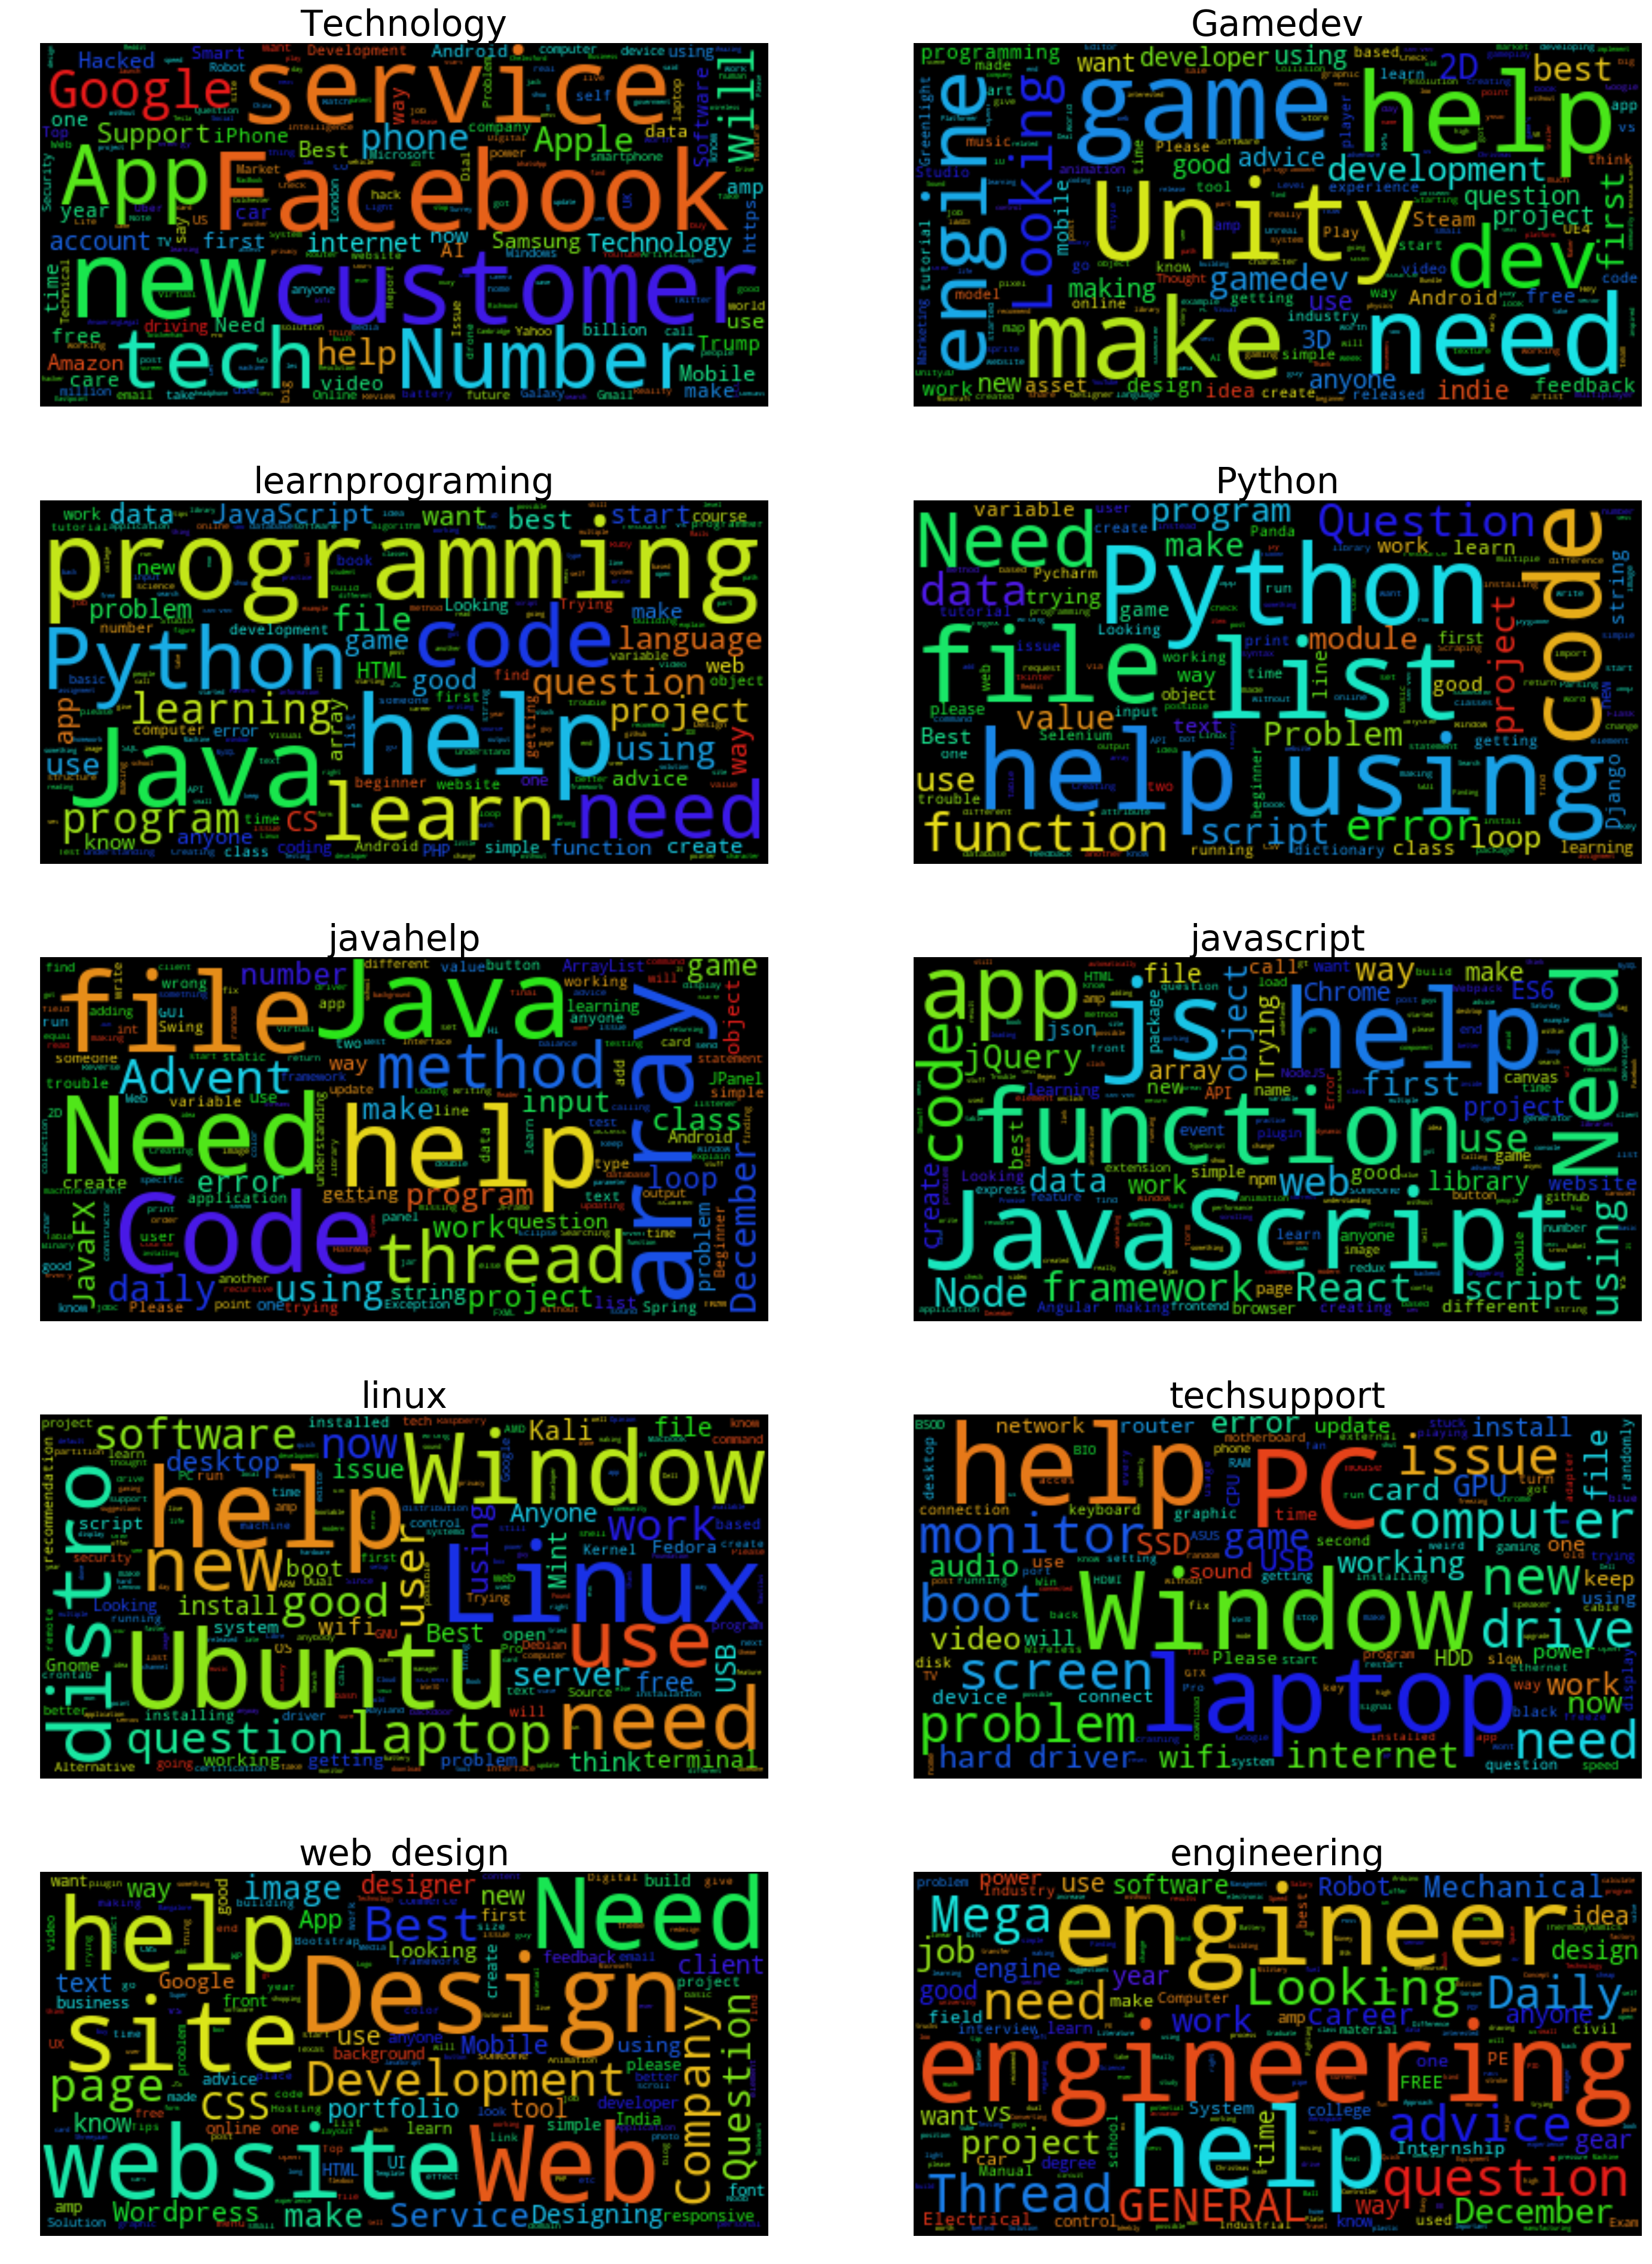

In [12]:
fig = plt.figure(figsize=(24,34))

plt.subplot(5,2,1)
words = ' '.join(df.loc[df['subreddit'] == 'technology','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Technology', fontsize=30)
plt.axis("off")

plt.subplot(5,2,2)
words = ' '.join(df.loc[df['subreddit'] == 'gamedev','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Gamedev', fontsize=30)
plt.axis("off")

plt.subplot (5,2,3)
words = ' '.join(df.loc[df['subreddit'] == 'learnprogramming','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('learnprograming', fontsize=30)
plt.axis("off")

plt.subplot (5,2,4)
words = ' '.join(df.loc[df['subreddit'] == 'Python','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Python', fontsize=30)
plt.axis("off")

plt.subplot (5,2,5)
words = ' '.join(df.loc[df['subreddit'] == 'javahelp','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('javahelp', fontsize=30)
plt.axis("off")

plt.subplot (5,2,6)
words = ' '.join(df.loc[df['subreddit'] == 'javascript','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('javascript', fontsize=30)
plt.axis("off")

plt.subplot (5,2,7)
words = ' '.join(df.loc[df['subreddit'] == 'linux','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('linux', fontsize=30)
plt.axis("off")

plt.subplot (5,2,8)
words = ' '.join(df.loc[df['subreddit'] == 'techsupport','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('techsupport', fontsize=30)
plt.axis("off")

plt.subplot (5,2,9)
words = ' '.join(df.loc[df['subreddit'] == 'web_design','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('web_design', fontsize=30)
plt.axis("off")

plt.subplot (5,2,10)
words = ' '.join(df.loc[df['subreddit'] == 'engineering','title'])
wordcloud = WordCloud(max_font_size = 60, stopwords = STOPWORDS).generate(words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('engineering', fontsize=30)
plt.axis("off");

In [13]:
# encode the subreddit column
# Use lebel encoder to convert the categories into numerical values 
le = LabelEncoder()
le.fit(df['subreddit'])
df['sub_code']=le.transform(df['subreddit'])

In [14]:
sub_codes = df.groupby(['subreddit','sub_code']).size().reset_index(name='post_count')
sub_codes

subreddit  sub_code  post_count
0            Python         0        2380
1       engineering         1         525
2           gamedev         2        1281
3          javahelp         3         536
4        javascript         4         546
5  learnprogramming         5        3448
6             linux         6         545
7        technology         7        2321
8       techsupport         8       11423
9        web_design         9         864

I created a function (cleaner) to use as the proprocesser for the TFIDF Vectorizer in order to simplify the dataset. The function uses WordNetLemmatizer PorterStemmer to consolidate different variations of similar words. Lemmatizing the dataset reduces words based on an actual dictionary or vocabulary, unlike stemming which reduces words regardless of their actual-word existence (e.g., "engineering" & "engineer" become "engin"). Therefore lemmatizing is better at retaining the true meaning of words and their part of speech.

In addition to lemmatizing, the cleaner function removes stop words. Stopwords are words that appear so commonly in the corpus that they are efftively meaningless and don't contribute much to the learning or predictive process so it is to our benefit to remove them.

In [15]:
def cleaner(text):
    lemm = WordNetLemmatizer()
#     stemmer = PorterStemmer()
    stop = stopwords.words('english')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().strip()
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(lemm.lemmatize(w.strip()))
    return ' '.join(final_text)

In [16]:
X = df['title']
tv = TfidfVectorizer(preprocessor=cleaner)
tv.fit(X);

<a id='frequency'></a>
## Word Frequency by Subreddit

Below is a visual representations of the word frequency for the top 20 words for each subreddit after lemmatization. Because lemmatizing does not reduce words as drastically as stemming, we end up with both **engineering** and **engineer** in the titles. 

Similarly to the word clouds created from the original titles, if we look at the plotted words for _learn programming_ and _learn python_ we will see that there are a lot of overlapping words. In fact, the 6th most common word in the _learn programming_ subreddit is **python**. The 2nd & 3rd words for _learn python_ and _learn programming_, respectively, are **help**.

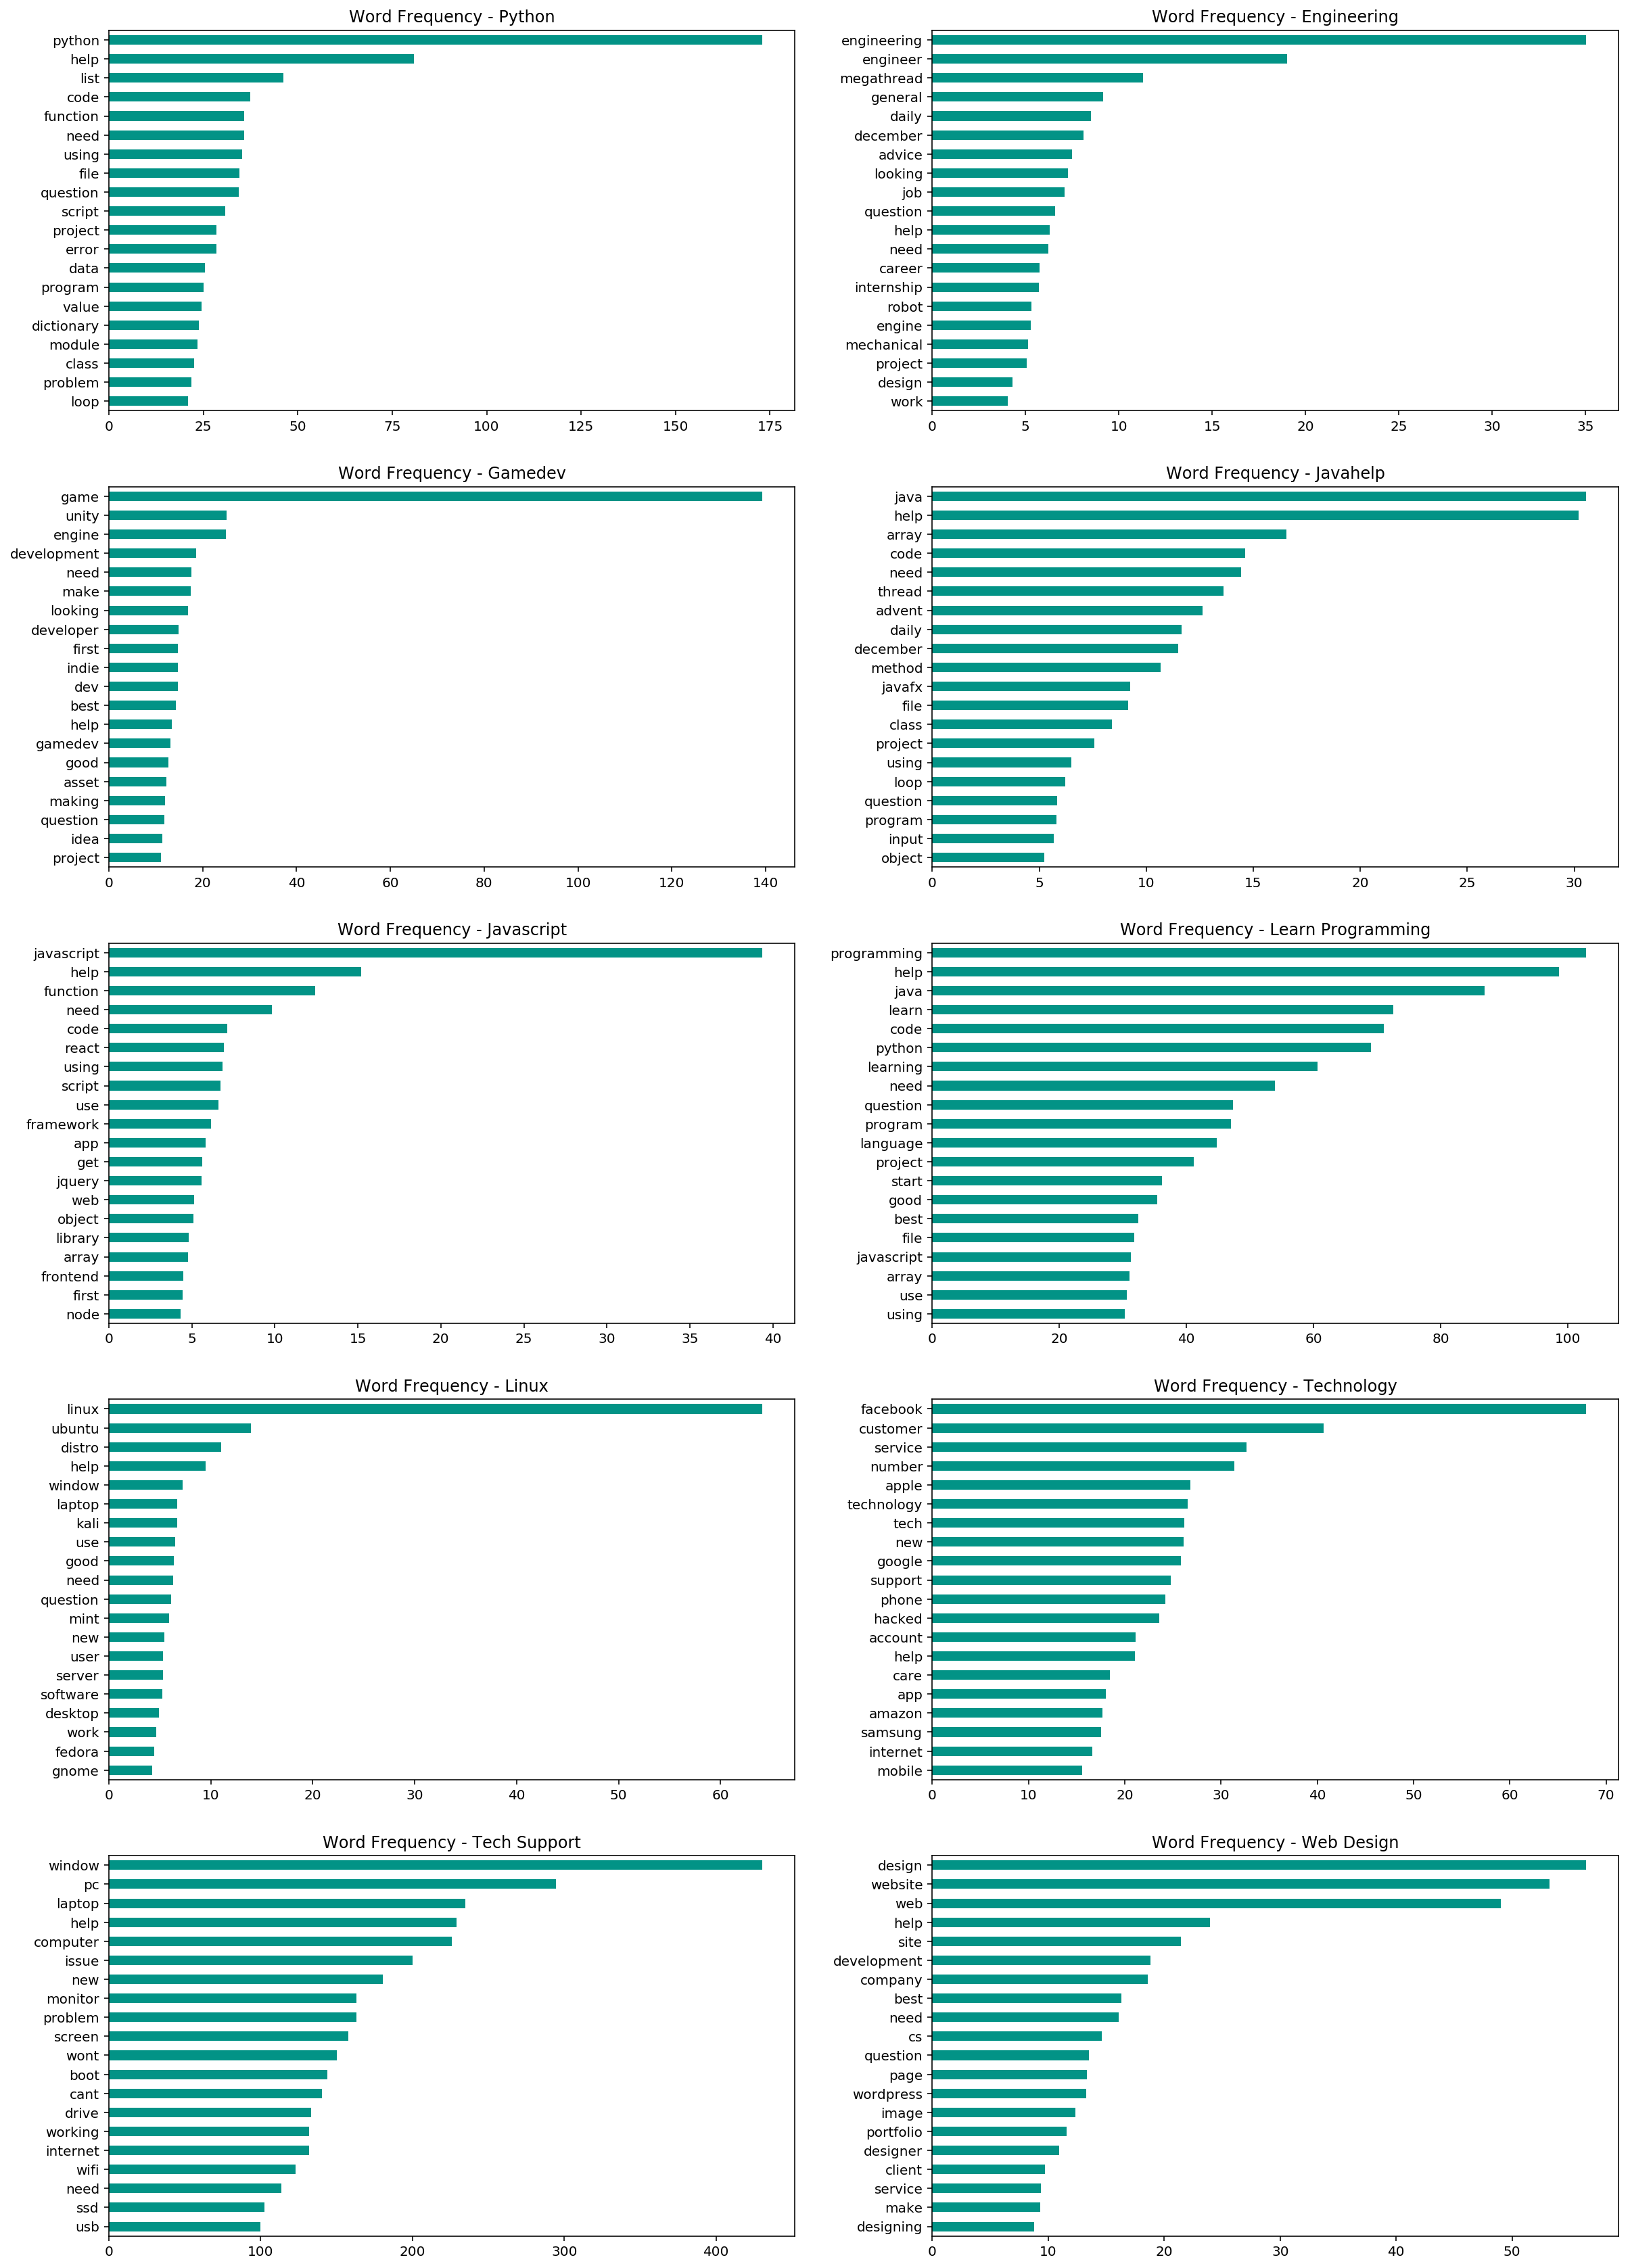

In [17]:
fig = plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
X = df.loc[df['sub_code'] == 0].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Python')

plt.subplot(5,2,2)
X= df.loc[df['sub_code'] == 1].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Engineering')

plt.subplot(5,2,3)
X= df.loc[df['sub_code'] == 2].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Gamedev')

plt.subplot(5,2,4)
X= df.loc[df['sub_code'] == 3].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Javahelp')

plt.subplot(5,2,5)
X= df.loc[df['sub_code'] == 4].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Javascript')

plt.subplot(5,2,6)
X= df.loc[df['sub_code'] == 5].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Learn Programming')

plt.subplot(5,2,7)
X= df.loc[df['sub_code'] == 6].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Linux')

plt.subplot(5,2,8)
X= df.loc[df['sub_code'] == 7].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Technology')

plt.subplot(5,2,9)
X= df.loc[df['sub_code'] == 8].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Tech Support')

plt.subplot(5,2,10)
X= df.loc[df['sub_code'] == 9].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Web Design');

<a id='target'></a>
# Target Variable

In [18]:
y = df['sub_code']
X = df['title']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.33, 
                                                    random_state = 24870, 
                                                    stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(15992,) (7877,) (15992,) (7877,)


During the train test split, I stratified on y to ensure that the distribution of subreddits is the same in both the test set & the training set. Below are plots of the resulting distribution for visual confirmation.

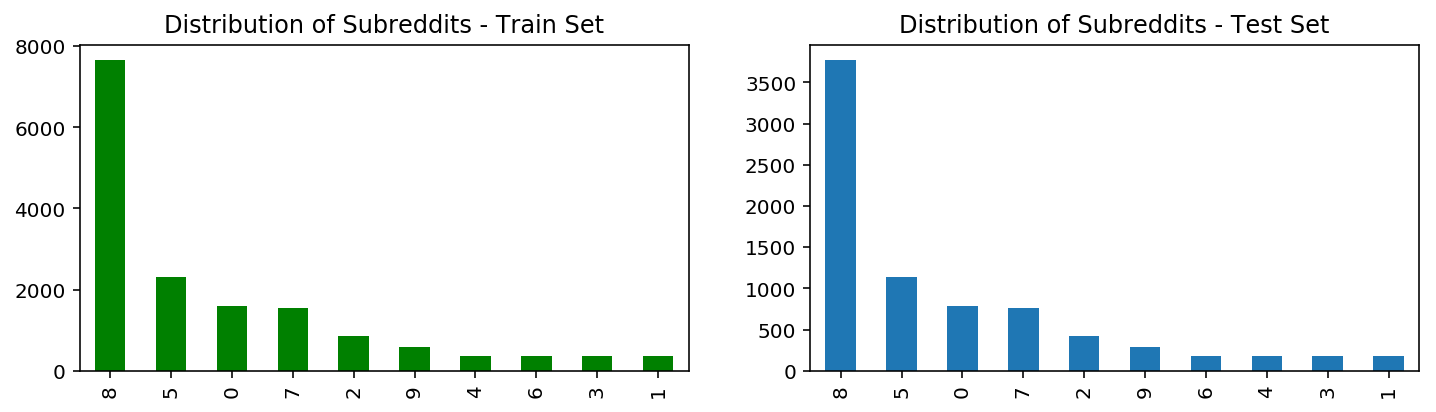

In [19]:
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
pd.value_counts(y_train).plot(kind="bar", color='green')
plt.title('Distribution of Subreddits - Train Set')

plt.subplot(1,2,2)
pd.value_counts(y_test).plot(kind="bar")
plt.title('Distribution of Subreddits - Test Set');

The techsupport subreddit is used to determine the baseline for the full dataset since it is the majority class.

In [20]:
baseline = y.value_counts()[8]/sum(y.value_counts())
baseline

0.47857053081402656

<a id='rfc'></a>
# Random Forest Classifier

Because their hierarchical structure allows them to learn from both classes, decision trees perform better on imbalanced data than other classification models even though they can be biased towards the dominate class and often have issues of overfitting.

TFIDF was chosen as the vectorizer instead of Count Vectorizer because I want to be able to use the most discriminatory words from each book description in the model instead of just the words that appear often. In the grid search parameters, I've includes the option for use_idf to be false so we can see which vectorizer works better.

In [23]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(preprocessor=cleaner)),
    ('rfc',RandomForestClassifier())
])

rfc_params = {
    'tfidf__max_features':[5000, 6000, 7000, 8000],
    'tfidf__use_idf':[True, False],
    'rfc__n_estimators':[150, 200, 250],
    'rfc__max_depth':[500, 550, 600, 650]
}

In [24]:
rfc_gs = GridSearchCV(pipe, cv = 2, param_grid=rfc_params)
rfc_gs.fit(X_train, y_train)

print("Best Score: ",rfc_gs.best_score_)
print("Best Params: ", rfc_gs.best_params_)

Best Score:  0.688156578289
Best Params:  {'rfc__max_depth': 600, 'rfc__n_estimators': 200, 'tfidf__max_features': 7000, 'tfidf__use_idf': False}


What is most interesting about the grid search results for this model is that the prefered setting for the use_idf parameter is **false**. Setting the use_idf parameter as false caused TFIDF to only look at the term frequency and not take into account the frequency of each word in the entire corpus. Because the titles are already short (between 7-10 words) users seem to be more selective of the words they use to desribe their post.

In [25]:
print("Train score: ",rfc_gs.score(X_train, y_train))
print("Test score: ", rfc_gs.score(X_test, y_test))
print(classification_report(y_test, rfc_gs.predict(X_test)))

Train score:  0.973986993497
Test score:  0.712961787483
             precision    recall  f1-score   support

          0       0.62      0.55      0.58       785
          1       0.78      0.34      0.47       173
          2       0.74      0.55      0.63       423
          3       0.55      0.10      0.17       177
          4       0.49      0.23      0.31       180
          5       0.61      0.55      0.58      1138
          6       0.69      0.36      0.47       180
          7       0.77      0.52      0.62       766
          8       0.75      0.96      0.84      3770
          9       0.62      0.49      0.55       285

avg / total       0.70      0.71      0.69      7877



On the surface this Random Forest Classifier is performing fairly well with a test score of 0.71 but if we look closer at the recall scores for each category we can see that the model is terrible at predicting half of the categories (less than 50% of the titles are predicted correctly). The subreddits that the model is bad at predicting are the ones with the smallest number of entries so the poor performance of this model can probably be attributed to the disproportionality of the dataset. The model is, as expected, excellent at predicting _techsupport_

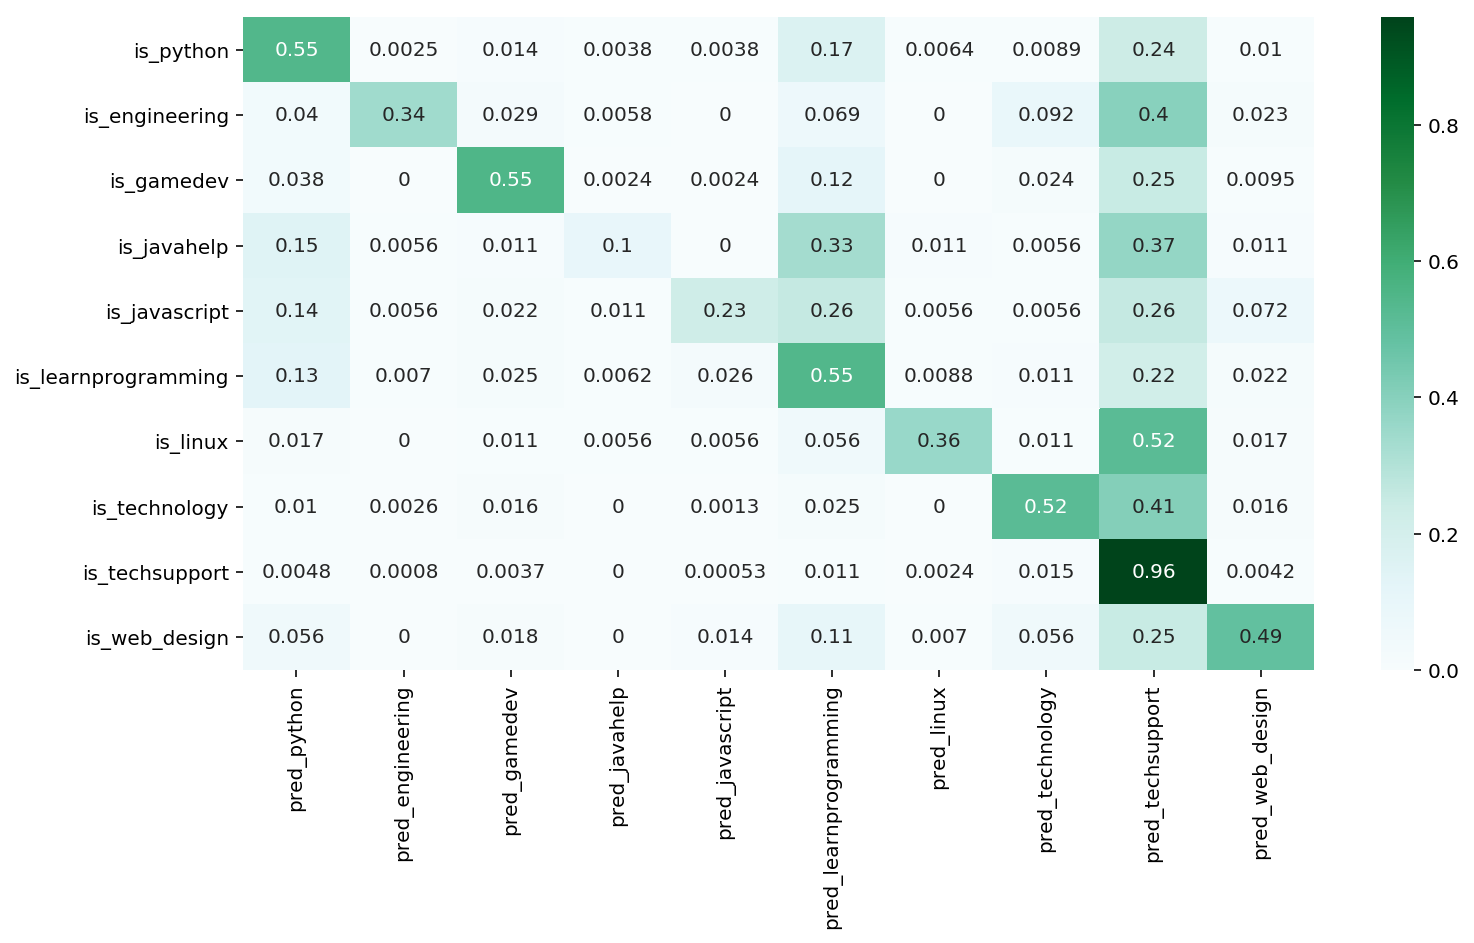

In [31]:
conmat = np.array(confusion_matrix(y_test, rfc_gs.predict(X_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_python','is_engineering', 'is_gamedev',
                                  'is_javahelp','is_javascript',
                                  'is_learnprogramming','is_linux','is_technology',
                                  'is_techsupport','is_web_design'],
                        columns=['pred_python','pred_engineering', 'pred_gamedev',
                                 'pred_javahelp','pred_javascript',
                                 'pred_learnprogramming','pred_linux','pred_technology',
                                 'pred_techsupport','pred_web_design'])
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'BuGn');

<a id='gbc'></a>
# Gradient Boosting Classifier

In an attempt to improve on the random forest model and minimize the overfitting seen in the training set, I decided to use a gradient boosting clasifier

In [24]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(preprocessor=cleaner)),
    ('gbc',GradientBoostingClassifier())
     ])

gbc_params = {
    'tfidf__max_features':[3000, 4000, 5000],
    'tfidf__use_idf':[True, False],
    'gbc__learning_rate':[0.10, 0.15, 0.20],
    'gbc__n_estimators':[550, 650, 750],
    'gbc__min_samples_leaf':[2,3, 4]
}

In [25]:
gbc_gs = GridSearchCV(pipe, cv = 2, param_grid = gbc_params)
gbc_gs.fit(X_train, y_train)

print("Best Score: ",gbc_gs.best_score_)
print("Best Params: ", gbc_gs.best_params_)

Best Score:  0.692221110555
Best Params:  {'gbc__learning_rate': 0.1, 'gbc__min_samples_leaf': 3, 'gbc__n_estimators': 750, 'tfidf__max_features': 5000, 'tfidf__use_idf': False}


Similarly to the Random Forest model, this model prefer for the use_idf parameter to be set to **False**. As discussed previously, this is probably due to users being more selectively with the words they choose for their post titles since the titles are short

In [26]:
print("Train score: ",gbc_gs.score(X_train, y_train))
print("Test score: ", gbc_gs.score(X_test, y_test))
print(classification_report(y_test, gbc_gs.predict(X_test)))

Train score:  0.873249124562
Test score:  0.716897295925
             precision    recall  f1-score   support

          0       0.69      0.53      0.60       785
          1       0.66      0.42      0.51       173
          2       0.69      0.60      0.64       423
          3       0.38      0.23      0.29       177
          4       0.40      0.24      0.30       180
          5       0.62      0.54      0.58      1138
          6       0.55      0.39      0.46       180
          7       0.74      0.51      0.61       766
          8       0.77      0.96      0.85      3770
          9       0.61      0.51      0.55       285

avg / total       0.70      0.72      0.70      7877



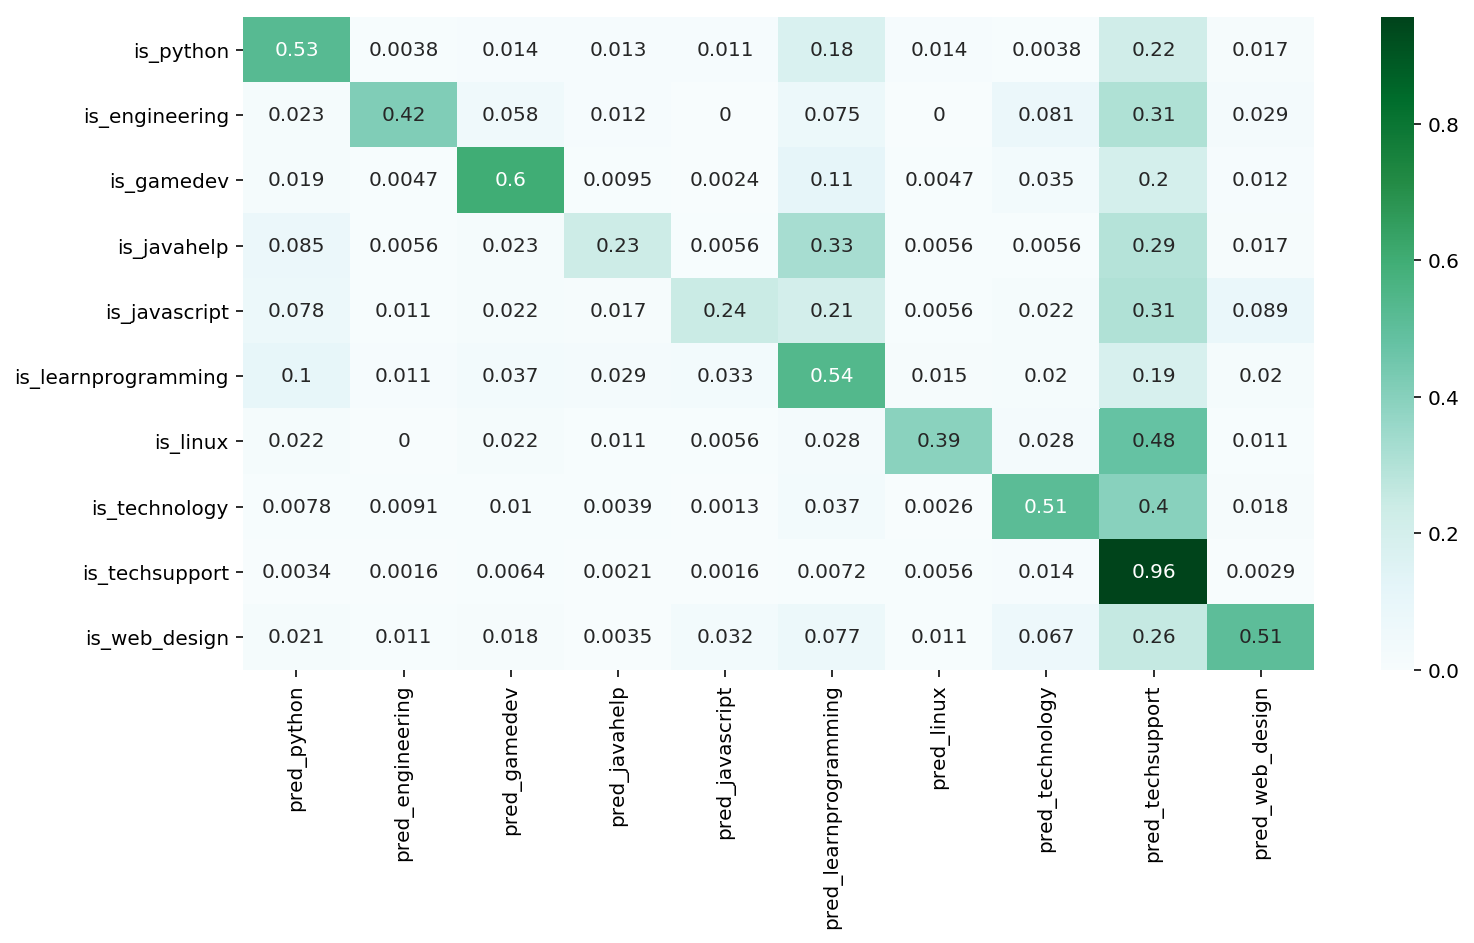

In [27]:
conmat = np.array(confusion_matrix(y_test, gbc_gs.predict(X_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_python','is_engineering', 'is_gamedev',
                                  'is_javahelp','is_javascript',
                                  'is_learnprogramming','is_linux','is_technology',
                                  'is_techsupport','is_web_design'],
                        columns=['pred_python','pred_engineering', 'pred_gamedev',
                                 'pred_javahelp','pred_javascript',
                                 'pred_learnprogramming','pred_linux','pred_technology',
                                 'pred_techsupport','pred_web_design'])
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'BuGn');

The test score for this model is approximately the same as that of the Random Forest model above. This model is noticably better at predicting the following subclasses: engineering (0.42 vs 0.35), gamedev (0.6 vs 0.55), javahelp (0.23 vs 0.1) and more or less the same (plus or minus 0.04) at predicting the other classes. Similarly to the random forest model, this model is over predicting subreddits to be techsupport. 

<a id='downsample'></a>
# Downsample Majority Class

As mentioned previously the data is disproportionately techsupport. The imbalanced data may cause models to overfit. I downsampled the largest genres (techsupport & learn_programming) using sklearn.utils.reampled because of its simplicity and created a downsampled version of the data for future models. I chose to downsample the data instead of upsampling the smaller subreddits because each title is distinct and duplicating any of the titles could distort the dataset by increasing the importance of words that may not actually be important.

In [37]:
from sklearn.utils import resample

df_majority = df[df.sub_code == 8]
df_minority = df[df.sub_code != 8]
df_majority_downsampled = resample(df_majority, replace=False, 
                                   n_samples=2500, random_state=240)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df_downsampled[df_downsampled.sub_code == 5]
df_minority = df_downsampled[df_downsampled.sub_code != 5]
df_majority_downsampled = resample(df_majority, replace=False, 
                                   n_samples=2500, random_state=240)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [38]:
sub_codes_down = df_downsampled.groupby(['subreddit',
                                    'sub_code']).size().reset_index(name='post_count')
sub_codes_down

subreddit  sub_code  post_count
0            Python         0        2380
1       engineering         1         525
2           gamedev         2        1281
3          javahelp         3         536
4        javascript         4         546
5  learnprogramming         5        2500
6             linux         6         545
7        technology         7        2321
8       techsupport         8        2500
9        web_design         9         864

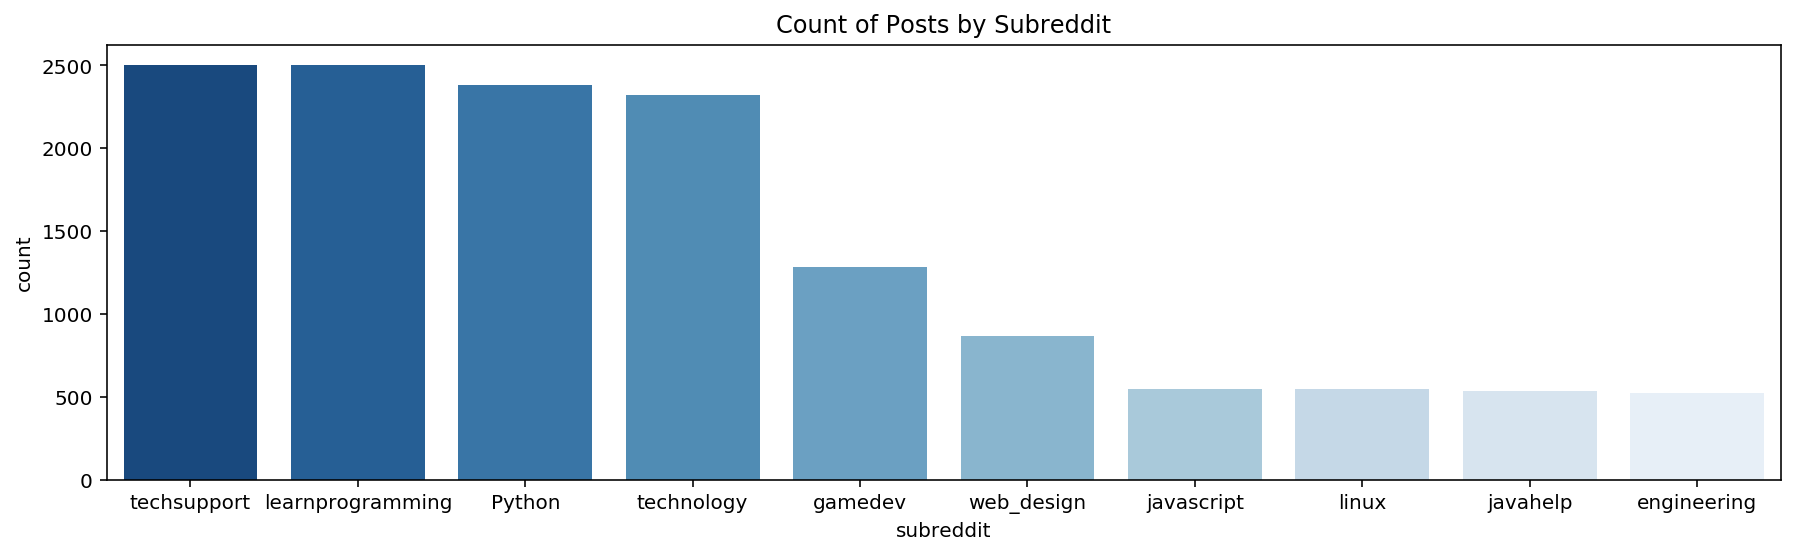

In [51]:
plt.subplots(figsize=(15,4)) 
plt.xticks(rotation=0, ha='center')
plt.title("Count of Posts by Subreddit")
sns.countplot(x='subreddit', data = df_downsampled, palette='Blues_r'
              , order = df_downsampled.subreddit.value_counts().index);

After downsampling the dataset is still imbalanced but it is significantly more even than previously. Depending on how the models perform, may need to resample further.

<a id='resample'></a>
# Resampled Target

In [39]:
y_down = df_downsampled['sub_code']
X_down = df_downsampled['title']

Xdown_train, Xdown_test, ydown_train, ydown_test = train_test_split(X_down, y_down, 
                                                                    test_size=0.33, 
                                                                    random_state=240, 
                                                                    stratify=y_down)
print(Xdown_train.shape, Xdown_test.shape, ydown_train.shape, ydown_test.shape)

(9378,) (4620,) (9378,) (4620,)


As with the full dataset, I stratified on the downsampled y classes. Below are plots of the resulting distribution for visual confirmation.

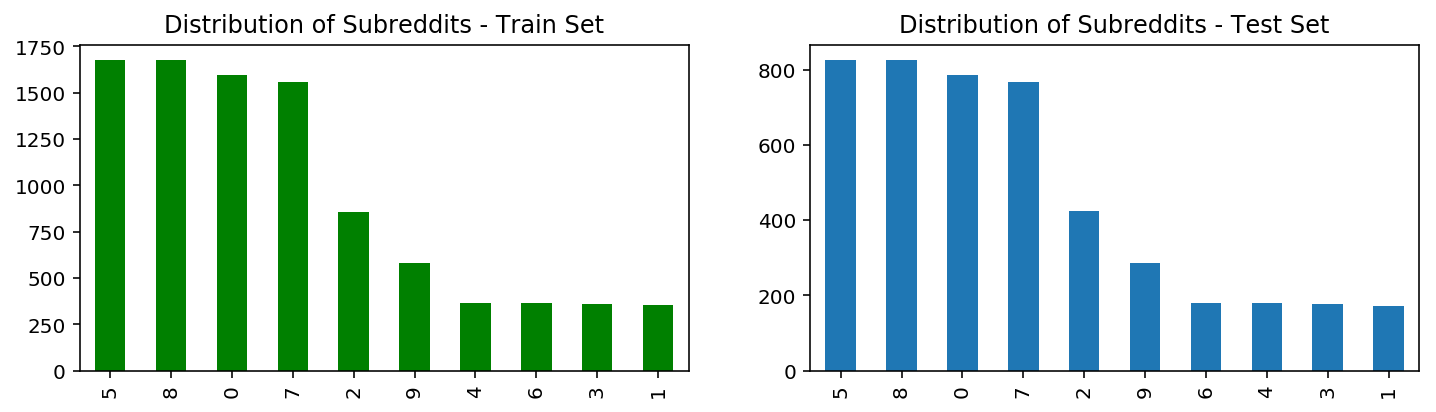

In [40]:
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
pd.value_counts(ydown_train).plot(kind="bar", color='green')
plt.title('Distribution of Subreddits - Train Set')

plt.subplot(1,2,2)
pd.value_counts(ydown_test).plot(kind="bar")
plt.title('Distribution of Subreddits - Test Set');

The baseline for the downsampled dataset is calculated using the techsupport category

In [41]:
baseline = y_down.value_counts()[8]/sum(y_down.value_counts())
baseline

0.17859694242034577

<a id='resample rfc'></a>
# Downsampled Random Forest Classifier

In [45]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(preprocessor=cleaner)),
    ('rfc',RandomForestClassifier())
])

rfc_params = {
    'tfidf__max_features':[5000, 6000, 7000],
    'tfidf__use_idf':[True, False],
    'rfc__n_estimators':[1500, 2000, 3500, 2500],
    'rfc__max_depth':[300, 400, 450]
}

In [46]:
# Using the Random Forest Classifier Gridsearch defined above
rfc_gs = GridSearchCV(pipe, cv = 2, param_grid=rfc_params)
rfc_gs.fit(Xdown_train, ydown_train)

print("Best Score: ",rfc_gs.best_score_)
print("Best Params: ", rfc_gs.best_params_)

Best Score:  0.575069311154
Best Params:  {'rfc__max_depth': 400, 'rfc__n_estimators': 2000, 'tfidf__max_features': 6000, 'tfidf__use_idf': True}


The downsampled random forest model prefers to have the **use_idf** parameter as True while the same model run on the full dataset  

In [47]:
print("Train score: ",rfc_gs.score(Xdown_train, ydown_train))
print("Test score: ", rfc_gs.score(Xdown_test, ydown_test))
print(classification_report(ydown_test, rfc_gs.predict(Xdown_test)))

Train score:  0.96438473022
Test score:  0.608874458874
             precision    recall  f1-score   support

          0       0.56      0.70      0.62       786
          1       0.70      0.32      0.44       173
          2       0.76      0.58      0.66       423
          3       0.56      0.14      0.22       177
          4       0.58      0.26      0.36       180
          5       0.53      0.49      0.51       825
          6       0.73      0.38      0.50       180
          7       0.55      0.79      0.65       766
          8       0.72      0.78      0.75       825
          9       0.64      0.60      0.62       285

avg / total       0.62      0.61      0.59      4620



If we look at the overall text scores, the downsampled Random Forest Classifier doesn't perform as well as the RFC on the full dataset. However, looking closer at the recall scores for each categories we can see that the downsampled model is better at predicting _python_, _learnprogramming_, _technology_, & _web_design_. The change in test accuracy can mostly be attributed to the change in the predictive accuracy for _techsupport_. In the model that was run on the full dataset, the accuracy for _techsupport_ is 96% and in the downsampled model it is 78%. This change should be expected since the downsampled dataset is no longer as imbalanced 

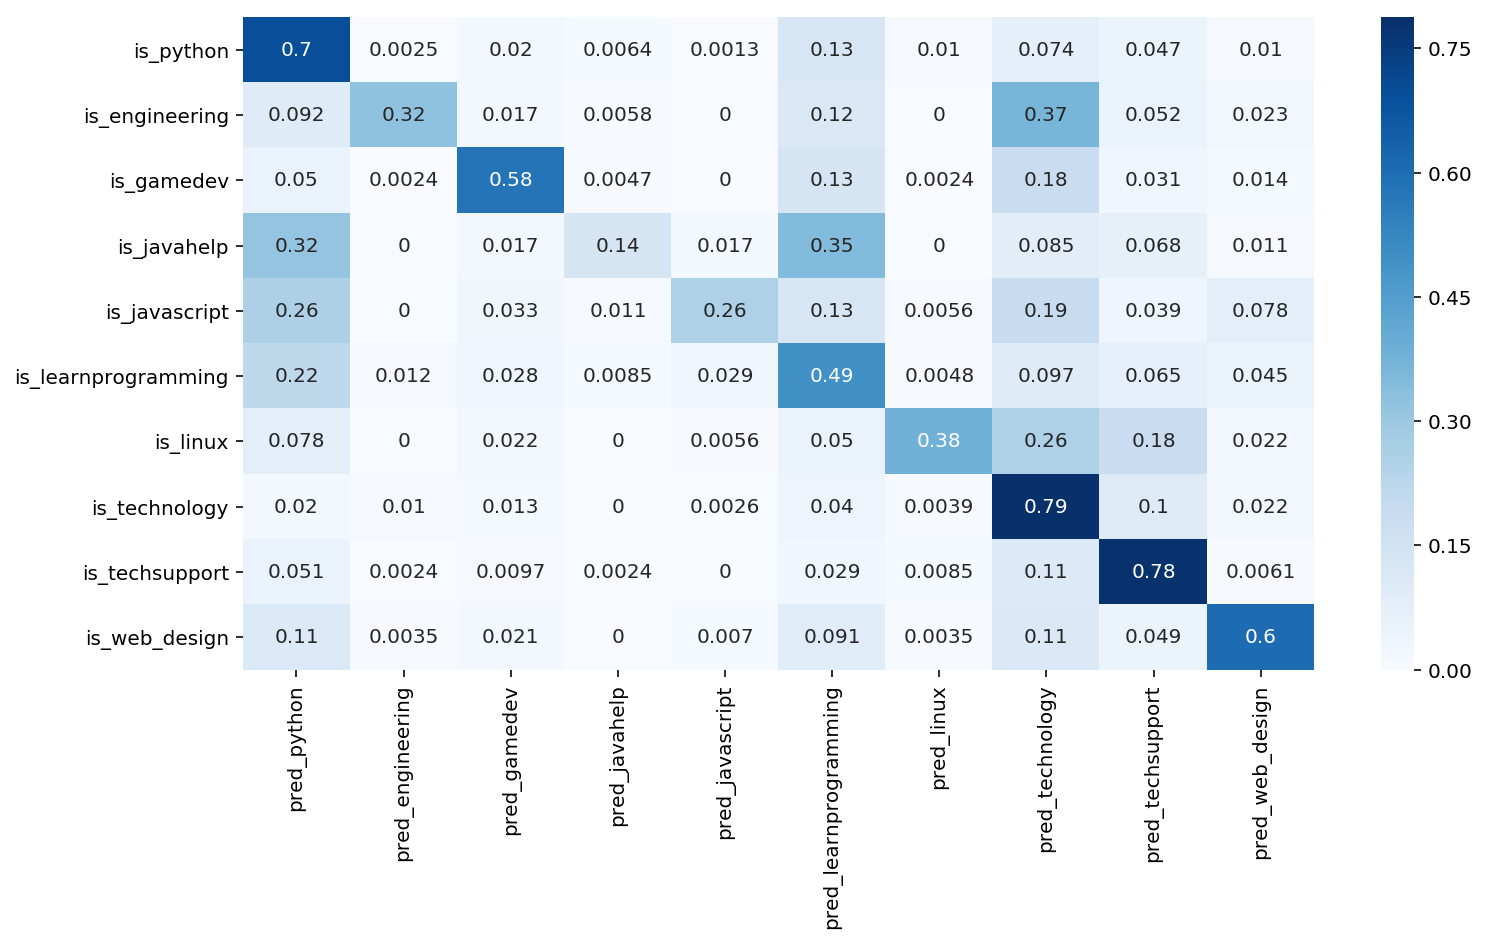

In [48]:
conmat = np.array(confusion_matrix(ydown_test, rfc_gs.predict(Xdown_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_python','is_engineering', 'is_gamedev',
                                  'is_javahelp','is_javascript',
                                  'is_learnprogramming','is_linux','is_technology',
                                  'is_techsupport','is_web_design'],
                        columns=['pred_python','pred_engineering', 'pred_gamedev',
                                 'pred_javahelp','pred_javascript',
                                 'pred_learnprogramming','pred_linux','pred_technology',
                                 'pred_techsupport','pred_web_design'])
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

<a id='downsampled gbc'></a>
# Downsampled Gradient Boosting Classifier

In [57]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(preprocessor=cleaner)),
    ('gbc',GradientBoostingClassifier())
     ])

gbc_params = {
    'tfidf__max_features':[4000, 5000, 6000],
    'tfidf__use_idf':[True, False],
    'gbc__learning_rate':[0.05, 0.10],
    'gbc__n_estimators':[450, 550],
    'gbc__min_samples_leaf':[2,3,4]
}

In [58]:
gbc_gs = GridSearchCV(pipe, cv = 2, param_grid = gbc_params)
gbc_gs.fit(Xdown_train, ydown_train)

print("Best Score: ",gbc_gs.best_score_)
print("Best Params: ", gbc_gs.best_params_)

Best Score:  0.563659628919
Best Params:  {'gbc__learning_rate': 0.1, 'gbc__min_samples_leaf': 3, 'gbc__n_estimators': 450, 'tfidf__max_features': 5000, 'tfidf__use_idf': False}


In [59]:
print("Train score: ",gbc_gs.score(Xdown_train, ydown_train))
print("Test score: ", gbc_gs.score(Xdown_test, ydown_test))
print(classification_report(ydown_test, gbc_gs.predict(Xdown_test)))

Train score:  0.813712945191
Test score:  0.6170995671
             precision    recall  f1-score   support

          0       0.67      0.67      0.67       786
          1       0.59      0.35      0.44       173
          2       0.72      0.62      0.67       423
          3       0.46      0.23      0.31       177
          4       0.48      0.31      0.37       180
          5       0.51      0.55      0.53       825
          6       0.61      0.47      0.53       180
          7       0.57      0.73      0.64       766
          8       0.73      0.78      0.75       825
          9       0.61      0.60      0.61       285

avg / total       0.62      0.62      0.61      4620



The downsampled gradient boost model is slightly better at predicting _javascript_ & _engineering_ which were two of the harder subreddits to accurately predict. The training score is closer to the testing score. I believe that this model will work better on unseen datasets compared with previous models.

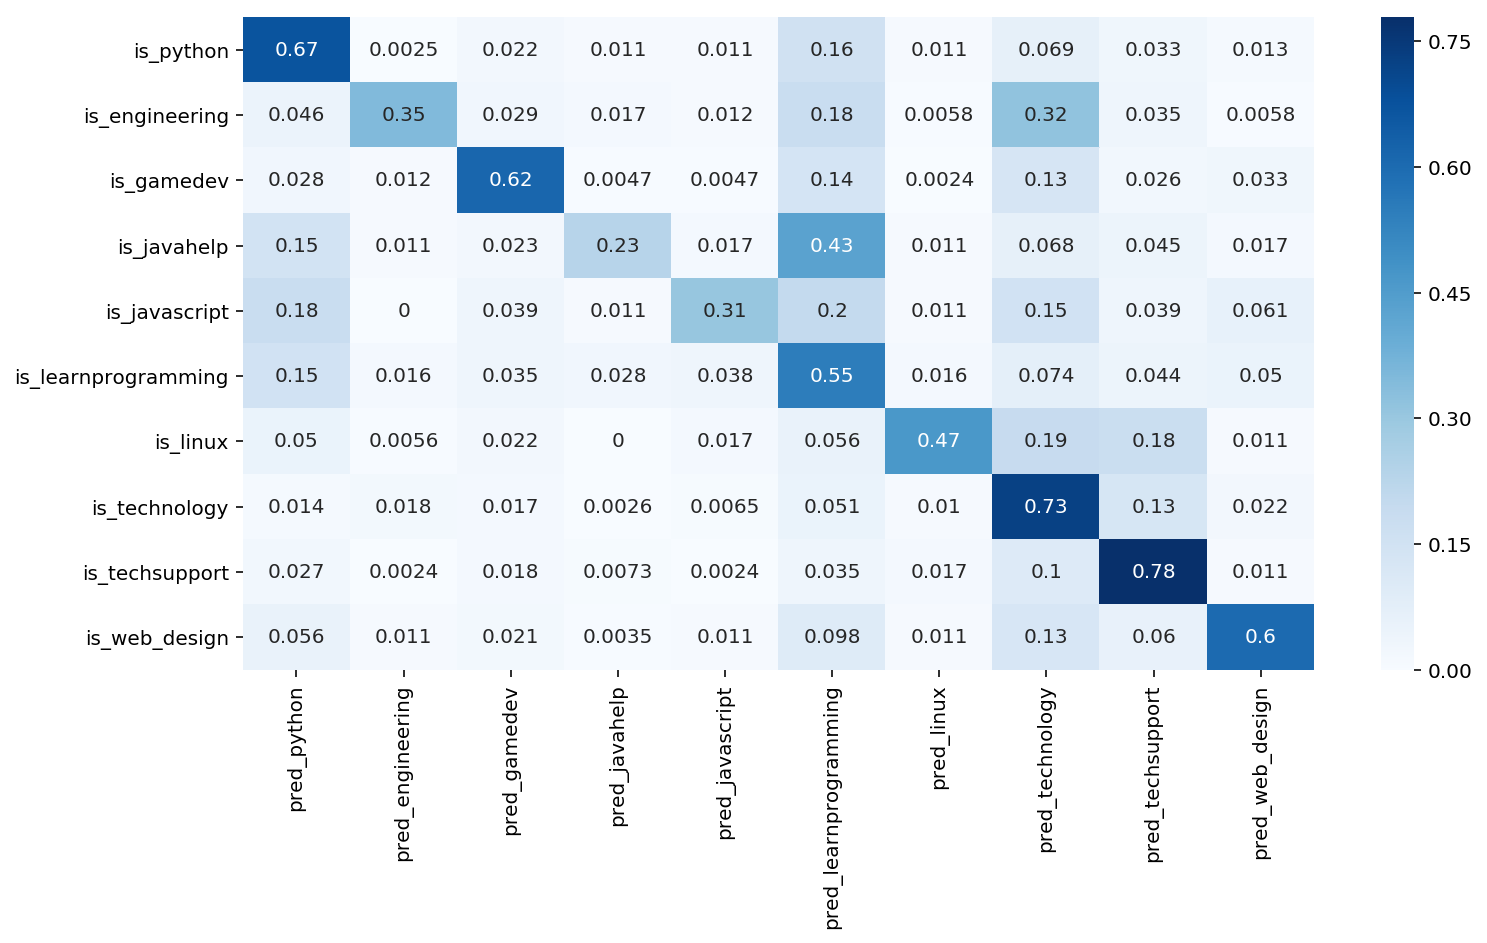

In [60]:
conmat = np.array(confusion_matrix(ydown_test, gbc_gs.predict(Xdown_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_python','is_engineering', 'is_gamedev',
                                  'is_javahelp','is_javascript',
                                  'is_learnprogramming','is_linux','is_technology',
                                  'is_techsupport','is_web_design'],
                        columns=['pred_python','pred_engineering', 'pred_gamedev',
                                 'pred_javahelp','pred_javascript',
                                 'pred_learnprogramming','pred_linux','pred_technology',
                                 'pred_techsupport','pred_web_design'])
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

<a id='conclusions'></a>
# Conclusions & Takeaways

The gradient boost classification model that was fit on the downsampled dataset proved to be the best classifier. The downsampled baseline accuracy is 18% and the test accuracy is 60.5%. Both gradient boost models have training scores that are closer to their test scores compared to the random forest models. This suggests that they are less overfit and would probably be more easily generalizable.

The model is not as good at predicting _techsupport_ as previous models; 76% accuracy as opposed to the 78% from the downsampled random forest, 95% from the gradient boost and 96% from the random forest.

The best score occurs when the **use\_idf** parameter for the TFIDF Vectorizer is set to False, effectively making it a CountVectorizer.

                        names  train   test
0               Random Forest  0.964  0.712
1              Gradient Boost  0.834  0.705
2   Downsampled Random Forest  0.969  0.609
3  Downsampled Gradient Boost  0.776  0.605


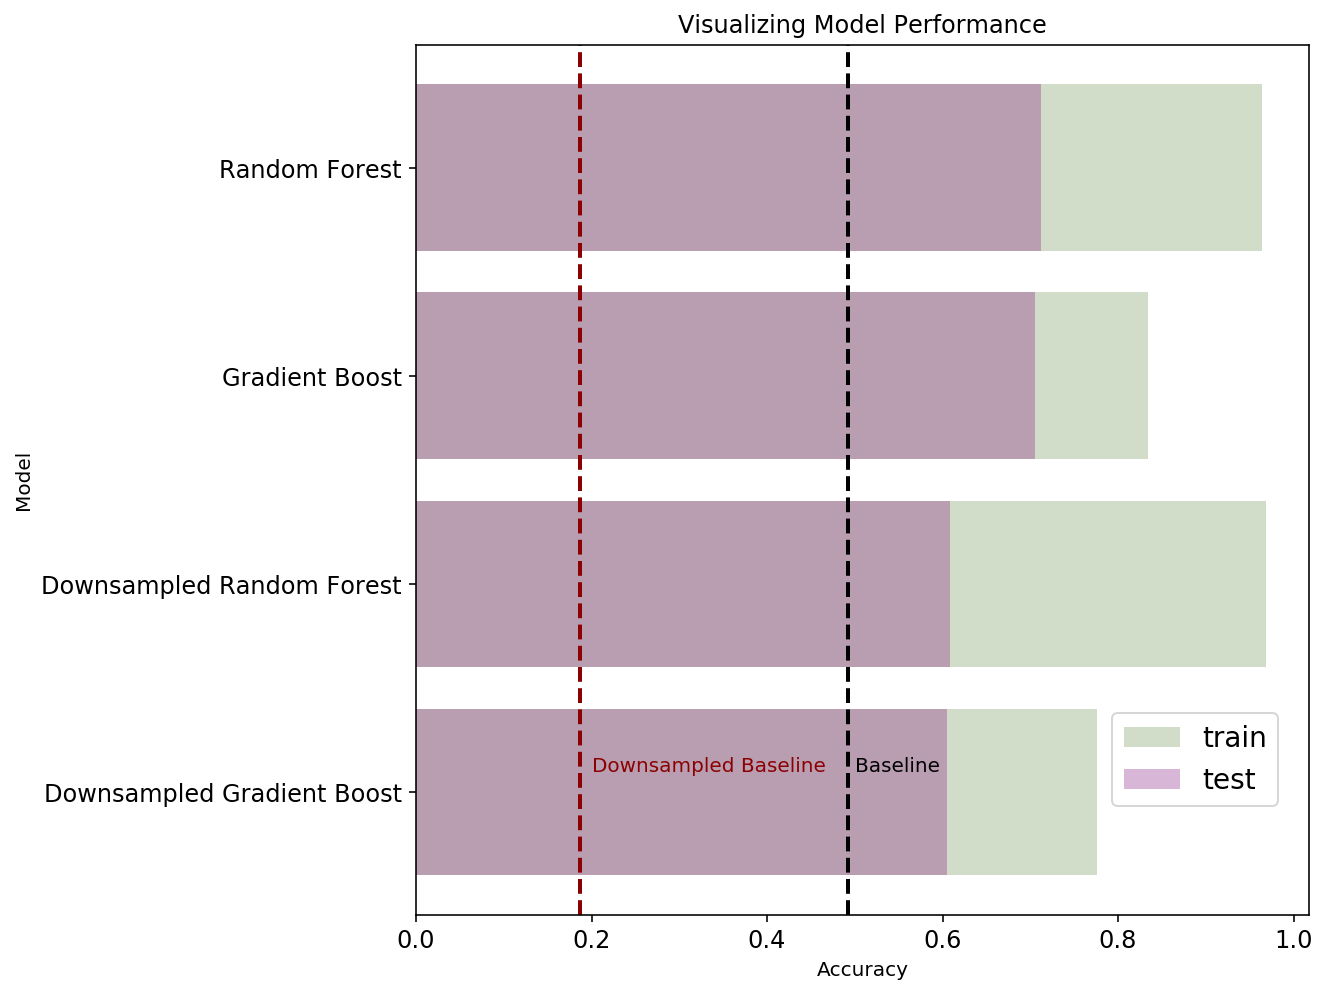

In [42]:
names = ['Random Forest',
        'Gradient Boost',
        'Downsampled Random Forest',
        'Downsampled Gradient Boost']
train = [0.964,
         0.834,
         0.969,
         0.776]
test = [0.712,
       0.705,
       0.609,
       0.605]

accuracy_dct = dict(zip(names, train))

accuracy_df = pd.DataFrame(list(accuracy_dct.items()), columns = ['names','train'])
accuracy_df['test'] = test
print(accuracy_df)

# plot as bar chart

names = accuracy_df['names']

# sort importances
indices = np.argsort(accuracy_df['test'])

# plot as bar chart
fig = plt.figure(figsize=(8, 8))
plt.barh(np.arange(len(names)), accuracy_df['train'][indices], alpha = .3,
         color = '#6d904f', label = 'train')
plt.barh(np.arange(len(names)), accuracy_df['test'][indices], alpha = .3, 
         color = '#810f7c', label = 'test')
plt.yticks(np.arange(len(names)), np.array(names)[indices], size=12)
plt.xticks(size=12)
_ = plt.ylabel('Model')
_ = plt.xlabel('Accuracy')
_ = plt.title('Visualizing Model Performance')
plt.axvline(x=0.492, color='black', linestyle='--', lw=2)
plt.text(0.5, 0.1, 'Baseline',
        color='black', fontsize=10)
plt.axvline(x=0.187, color='darkred', linestyle='--', lw=2)
plt.text(0.20, 0.1, 'Downsampled Baseline',
        color='darkred', fontsize=10)
plt.legend(loc=(.78, .125), fontsize=14);

In [61]:
tv = TfidfVectorizer(stop_words='english', max_features=5000, use_idf=False)
X_train_tv = tv.fit_transform(Xdown_train)
X_test_tv = tv.transform(Xdown_test)

gbc = GradientBoostingClassifier(learning_rate=0.1, min_samples_leaf=3, n_estimators=450)
gbc.fit(X_train_tv, ydown_train);

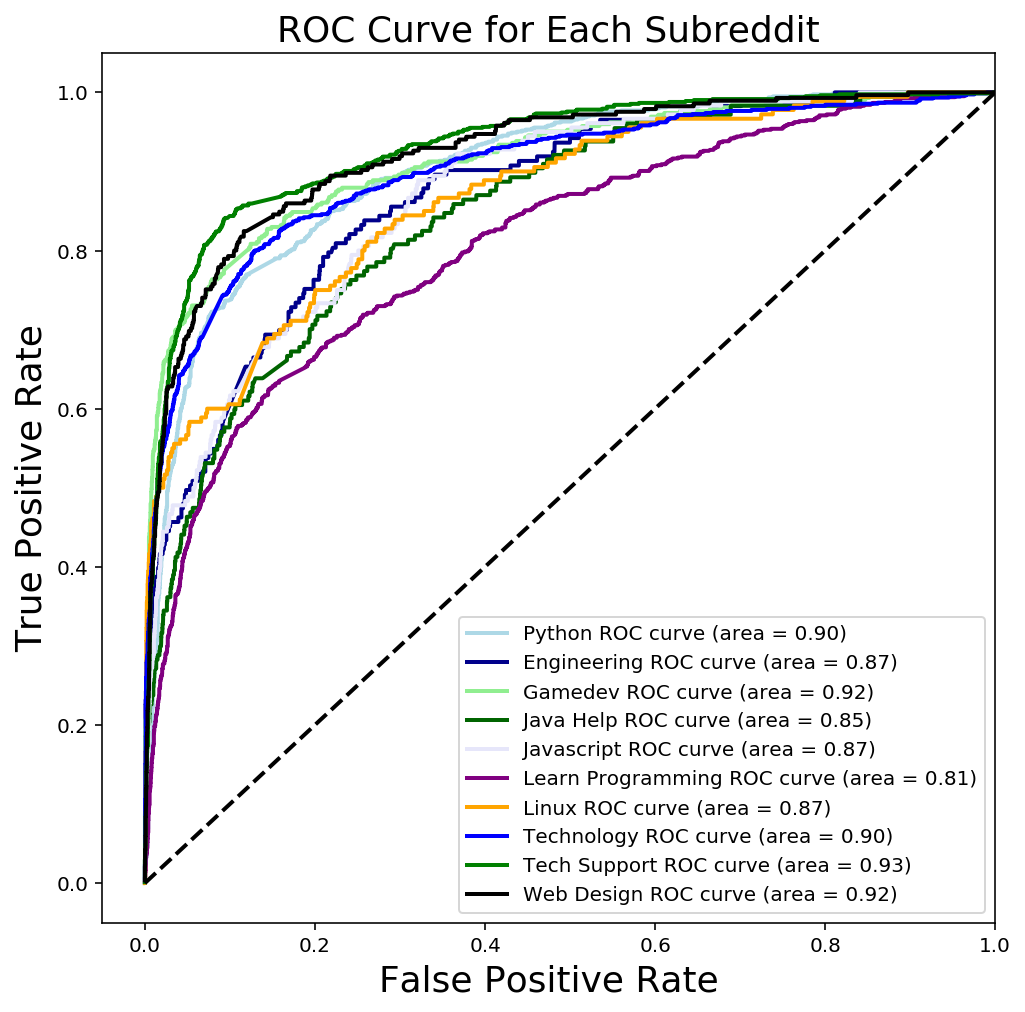

In [64]:
# roc curve
# get y_score for predicted probabilities
y_predict_proba = gbc.predict_proba(X_test_tv)

# generate fpr, tpr, and auc for each class
fpr0, tpr0, thresh0 = roc_curve(ydown_test.map(lambda x: 1 if x == 0 else 0), 
                                y_predict_proba[:,0])
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, thresh1 = roc_curve(ydown_test.map(lambda x: 1 if x == 1 else 0),
                                y_predict_proba[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresh2 = roc_curve(ydown_test.map(lambda x: 1 if x == 2 else 0), 
                                y_predict_proba[:,2])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresh3 = roc_curve(ydown_test.map(lambda x: 1 if x == 3 else 0), 
                                y_predict_proba[:,3])
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, thresh4 = roc_curve(ydown_test.map(lambda x: 1 if x == 4 else 0), 
                                y_predict_proba[:,4])
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, thresh5 = roc_curve(ydown_test.map(lambda x: 1 if x == 5 else 0), 
                                y_predict_proba[:,5])
roc_auc5 = auc(fpr5, tpr5)

fpr6, tpr6, thresh2 = roc_curve(ydown_test.map(lambda x: 1 if x == 6 else 0), 
                                y_predict_proba[:,6])
roc_auc6 = auc(fpr6, tpr6)

fpr7, tpr7, thresh7 = roc_curve(ydown_test.map(lambda x: 1 if x == 7 else 0), 
                                y_predict_proba[:,7])
roc_auc7 = auc(fpr7, tpr7)

fpr8, tpr8, thresh8 = roc_curve(ydown_test.map(lambda x: 1 if x == 8 else 0), 
                                y_predict_proba[:,8])
roc_auc8 = auc(fpr8, tpr8)

fpr9, tpr9, thresh9 = roc_curve(ydown_test.map(lambda x: 1 if x == 9 else 0), 
                                y_predict_proba[:,9])
roc_auc9 = auc(fpr9, tpr9)

# plot all nine together
plt.figure(figsize=[8,8])
plt.plot(fpr0, tpr0, label='Python ROC curve (area = %0.2f)' % roc_auc0,
         linewidth=2, color = 'lightblue')
plt.plot(fpr1, tpr1, label='Engineering ROC curve (area = %0.2f)' % roc_auc1, linewidth=2, color = 'darkblue')
plt.plot(fpr2, tpr2, label='Gamedev ROC curve (area = %0.2f)' % roc_auc2, linewidth=2, color = 'lightgreen')
plt.plot(fpr3, tpr3, label='Java Help ROC curve (area = %0.2f)' % roc_auc3, linewidth=2, color='darkgreen')
plt.plot(fpr4, tpr4, label='Javascript ROC curve (area = %0.2f)' % roc_auc4, linewidth=2, color = 'lavender')
plt.plot(fpr5, tpr5, label='Learn Programming ROC curve (area = %0.2f)' % roc_auc5, linewidth=2, color = 'purple')
plt.plot(fpr6, tpr6, label='Linux ROC curve (area = %0.2f)' % roc_auc6, linewidth=2, color = 'orange')
plt.plot(fpr7, tpr7, label='Technology ROC curve (area = %0.2f)' % roc_auc7, linewidth=2, color = 'blue')
plt.plot(fpr8, tpr8, label='Tech Support ROC curve (area = %0.2f)' % roc_auc8, linewidth=2, color = 'green')
plt.plot(fpr9, tpr9, label='Web Design ROC curve (area = %0.2f)' % roc_auc9, linewidth=2, color = 'black')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve for Each Subreddit', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Next Steps

As the name implies Term Frequency Inverse Document Frequency can only look at how often a word occurs in a corpus. In order to improve the missclassifications due to commonly occuring words, I want to use Word2Vec to provide context to each word.

I also want to look at different methods of resampling to see how that impacts the  I specifically want to upsample the minority classes